# Loading and processing data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from scipy.stats import shapiro
import scipy.stats as stats

import warnings 

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./AB_Test_Results.csv')

### Making groups independent 

In [3]:
df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

In [4]:
uniq_df = (df.groupby('USER_ID')['VARIANT_NAME'].nunique() == 1)

In [5]:
uniq_df = uniq_df[uniq_df]

In [6]:
df = df[df['USER_ID'].isin(uniq_df.index)]

Data distribution and outlier detection 

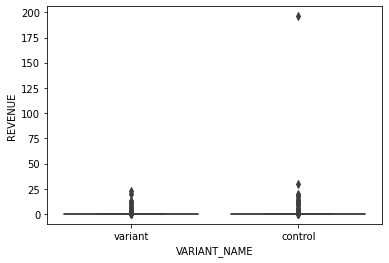

In [7]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df);

In [8]:
df.sort_values(by='REVENUE', ascending=False).iloc[:5]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47


In [9]:
df = df[df['USER_ID'] != 3342]

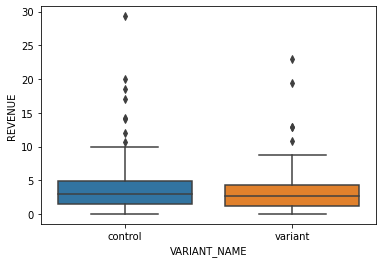

In [10]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data = df[df['REVENUE'] > 0]);

In [11]:
df = df.groupby(by=['USER_ID', 'VARIANT_NAME']).sum().reset_index()

In [12]:
# general stats
all_stat = df.groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                               'REVENUE': ['sum', 'mean', 'median', 'count']})

orders_per_user = all_stat.loc[:, ('REVENUE', 'count')] / all_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = all_stat.loc[:, ('REVENUE', 'sum')] / all_stat.loc[:, ('USER_ID', 'nunique')]

all_stat.loc[:, ('per_user', 'orders')] = orders_per_user
all_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

all_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control         2389  274.55  0.114923    0.0  2389      1.0  0.114923
variant         2393  179.32  0.074935    0.0  2393      1.0  0.074935

In [13]:
#only paying users stats
paid_stat = df.loc[df.REVENUE != 0].groupby(by='VARIANT_NAME').agg({'USER_ID': 'nunique',
                                                                     'REVENUE': ['sum', 'mean', 'median', 'count']})

orders_per_user = paid_stat.loc[:, ('REVENUE', 'count')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
revenue_per_user = paid_stat.loc[:, ('REVENUE', 'sum')] / paid_stat.loc[:, ('USER_ID', 'nunique')]
paid_stat.loc[:, ('per_user', 'orders')] = orders_per_user
paid_stat.loc[:, ('per_user', 'revenue')] = revenue_per_user

paid_stat

USER_ID REVENUE                        per_user          
             nunique     sum      mean median count   orders   revenue
VARIANT_NAME                                                          
control           53  274.55  5.180189   2.99    53      1.0  5.180189
variant           42  179.32  4.269524   2.97    42      1.0  4.269524

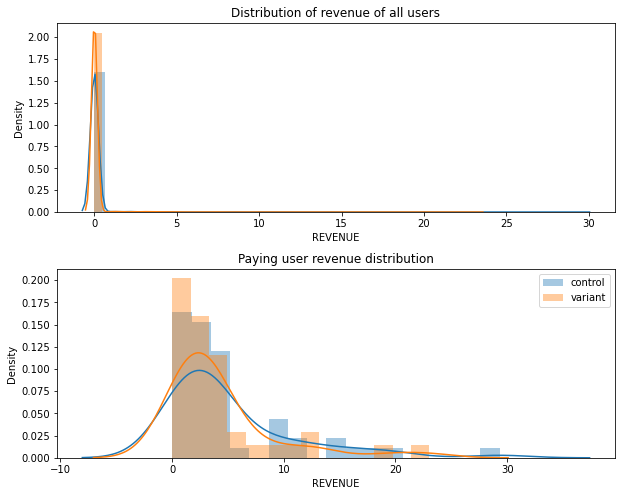

In [14]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3);

### Statistical Analysis 

In [15]:
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])

ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)

In [16]:
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

In [17]:
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'], 
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])

MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

In [18]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target, A, B):

    # Split A/B
    groupA = dataframe[dataframe[group] == A][target]
    groupB = dataframe[dataframe[group] == B][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    

Bootstrap

In [19]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [20]:
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [21]:
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)

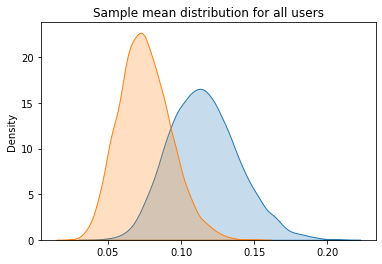

In [22]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users');

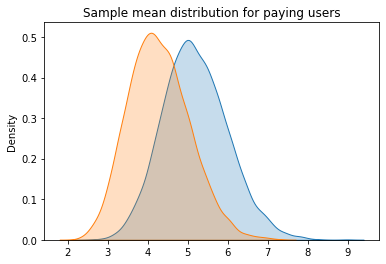

In [23]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users');

### Conclusion 

Despite of the visual difference between gorups we can't say that there is any statistical difference on the revenues of the control and variant variables because  p value is greater than 0.05 -> H0 HYPOTESIS IS NOT REJECTED!

In [24]:
AB_Test(dataframe=df, group="VARIANT_NAME", target="REVENUE", A='control', B='variant')

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.247996,A/B groups are similar!
